In [10]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd
import pickle

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs
from configs import states_per_site

In [2]:
def cross_corr_from_pairwise(pairwise):
    results = []
    for i in range(len(pairwise)):
        results.append(np.roll(pairwise[i], -i))
    return np.roll(np.mean(results, 0), len(pairwise)//2)

In [3]:
def proj(a, b):
    b_normalized = b / np.linalg.norm(b, axis=1, keepdims=True)
    return a - b_normalized * np.diag(np.tensordot(a, b_normalized, [1, 1]))[:, None]


In [4]:
def pairwise_cos_sim_centered(x):
    return pairwise_cos_sim(x - np.mean(x, axis=0, keepdims=True))

def pairwise_dot(x):
    return x @ x.transpose()

def pairwise_cos_sim(x):
    x_normalized = x / np.linalg.norm(x, axis=-1, keepdims=True)
    return x_normalized @ x_normalized.transpose()

corr_func = pairwise_cos_sim_centered

# Parameters and Initialization

In [5]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()

load = True

# Models

In [6]:
# RNN PARAMETERS
rec_strength_options = [1.0, 7.0, 20.0]

# FEEDFORWARD PARAMETERS
expansion = 20000
sparsity_options = [0.5, 0.05, 0.005]

if load:
    with open('pickles/fig2b_activity','rb') as f:
        results = pickle.load(f)
        rnn_barcodes = results['rnn_barcodes']
        ff_barcodes = results['ff_barcodes']
else:
    # RNN MODEL
    all_acts = []
    for rec_strength in rec_strength_options:        
        model = Model(N_inp, N_bar, num_states, steps=steps, weight_var=rec_strength)
        preacts, acts, _, _ = model.run_recurrent(place_inputs)

        model_input_strength_ratio = np.std(place_inputs) / np.std(preacts)
        model_sparsity = np.mean(acts>0)
        print(model_input_strength_ratio, model_sparsity)
        all_acts.append(acts)

    # FEEDFORWARD MODEL
    W1 = np.random.randn(N_inp, expansion) / np.sqrt(N_inp)
    W2 = np.random.randn(expansion, N_bar) / np.sqrt(expansion)

    ff_barcodes = np.zeros([len(sparsity_options), num_states, N_bar])
    ff_cache_acts = np.zeros([len(sparsity_options), num_states, N_bar])
    for i, s in enumerate(sparsity_options):
        hidden_preact = place_inputs @ W1
        T = np.percentile(hidden_preact, 100*(1.0-s))
        ff_barcode = np.clip(hidden_preact-T, 0, np.inf) @ W2
        ff_barcodes[i] = np.clip(ff_barcode - np.percentile(ff_barcode, 100*(1.0-model_sparsity)), 0, np.inf)

        ff_preacts = ff_barcode+place_inputs*model_input_strength_ratio*np.std(ff_barcode)/np.std(place_inputs)
        ff_cache_acts[i] = np.clip(ff_preacts- np.percentile(ff_preacts,100*(1.0-model_sparsity)), 0, np.inf)
        
    with open('pickles/fig2b_activity','wb') as f:
        pickle.dump({
            'rnn_barcodes': all_acts,
            'ff_barcodes': ff_barcodes
            }, f)

# Plot just recurrent

sigma=1.0
sigma=7.0
sigma=20.0


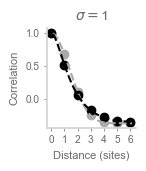

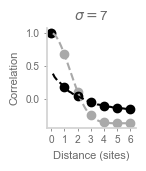

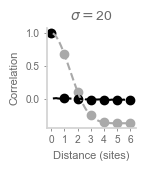

In [43]:
sites = np.arange(0, states_per_site*7, states_per_site)
for i, r in enumerate(rec_strength_options):
    print("sigma="+str(r))
    figsize=(1.5, 1.75)
    plt.figure(figsize=figsize)
    color=[0, 0, 1.5*(float(i)+2)/8, 1.5*(float(i)+2)/8]
    
    # Place Inputs
    line = cross_corr_from_pairwise(
        corr_func(np.clip(place_inputs, 0, np.inf)))
    line = line[len(line)//2:]
    line_start = 1
    plt.scatter(sites, line[sites], color='darkgrey')
    plt.plot(
        np.arange(line.size)[line_start:],
        line[line_start:],
        color='darkgrey',
        linewidth=1.5, linestyle='--')
    
    # Barcodes
    acts = rnn_barcodes[i]
    line = cross_corr_from_pairwise(corr_func(acts))
    line = line[len(line)//2:]
    line_start = 1
    plt.scatter(sites, line[sites], color='black')
    plt.plot(
        np.arange(line.size)[line_start:],
        line[line_start:],
        color='black',
        linewidth=1.5, linestyle='--')
    
    # Labels
    plt.xticks(sites, labels=np.arange(7))
    plt.yticks([0, 0.5, 1.0])
    plt.xlabel("Distance (sites)")
    plt.ylabel("Correlation")
    plt.title(r'$\sigma=$'+str(int(r)), fontsize=10)
    plt.tight_layout()
    plt.savefig(f'figures/fig2b_{i}.svg', dpi=300, transparent=True)

# Plot recurrent v FF

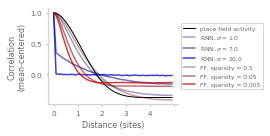

In [15]:
figsize=(4, 2)
plt.figure(figsize=figsize)
corr_func = pairwise_cos_sim_centered

line = cross_corr_from_pairwise(corr_func(np.clip(place_inputs, 0, np.inf)))
plt.plot(
    line[len(line)//2:],
    color="black", label="place field activity")

for i, r in enumerate(rec_strength_options):
    acts = all_acts[i]
    line = cross_corr_from_pairwise(corr_func(acts))
    plt.plot(line[len(line)//2:],
            color=[0, 0, 1.5*(float(i)+2)/8, 1.5*(float(i)+2)/8],
             label=f"RNN, $\sigma=$"+str(r), linewidth=1.5)
for i, s in enumerate(sparsity_options):
    line = cross_corr_from_pairwise(corr_func(ff_barcodes[i]))
    plt.plot(line[len(line)//2:],
            color=[1.5*(float(i)+2)/8, 0, 0, 1.5*(float(i)+2)/8],
             label="FF, sparsity = "+str(s), linewidth=1.5)
    
# Put a legend to the right of the current axis
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
plt.xticks(
    np.arange(0, 60, 10),
    labels=np.arange(5)
    )
plt.xlabel("Distance (sites)")
plt.ylabel("Correlation\n(mean-centered)")
plt.tight_layout()
plt.savefig('figures/figs2b_b.svg', dpi=300, transparent=True)

# Plot example FF barcodes

In [16]:
n_units = ff_barcodes.shape[-1]

In [17]:
n_samples = 100

In [18]:
import matplotlib.patches as patches

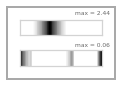

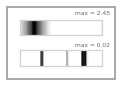

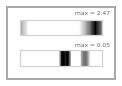

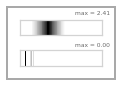

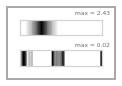

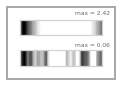

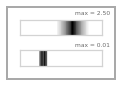

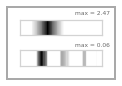

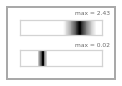

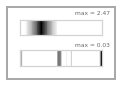

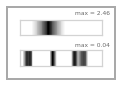

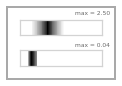

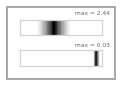

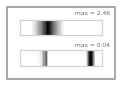

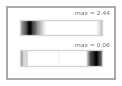

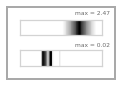

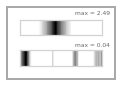

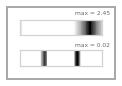

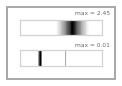

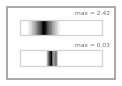

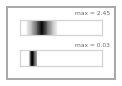

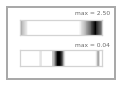

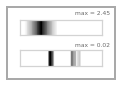

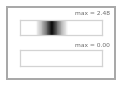

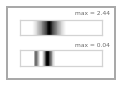

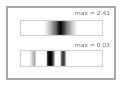

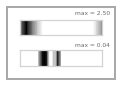

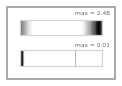

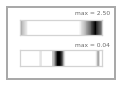

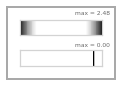

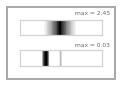

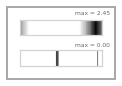

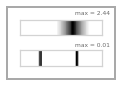

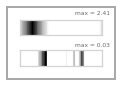

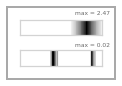

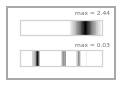

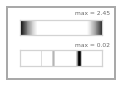

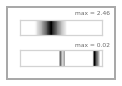

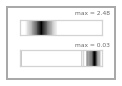

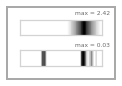

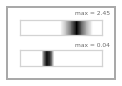

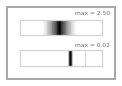

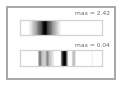

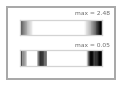

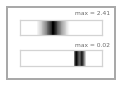

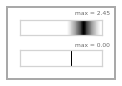

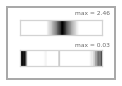

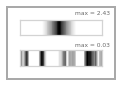

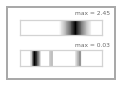

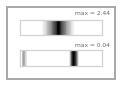

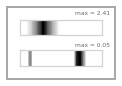

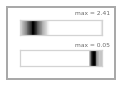

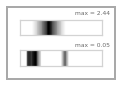

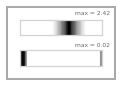

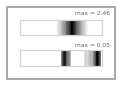

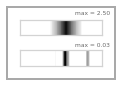

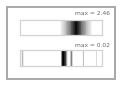

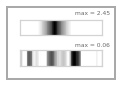

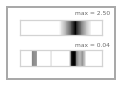

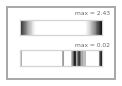

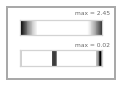

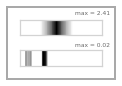

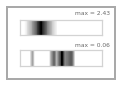

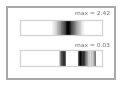

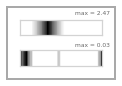

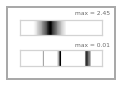

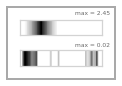

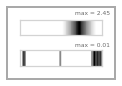

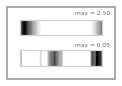

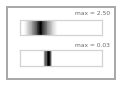

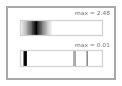

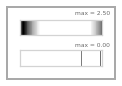

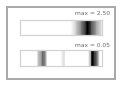

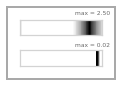

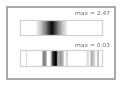

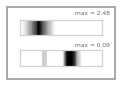

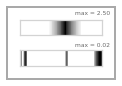

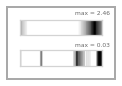

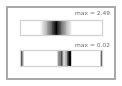

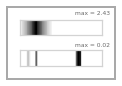

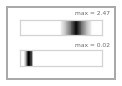

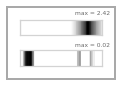

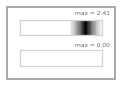

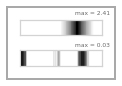

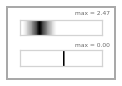

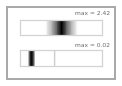

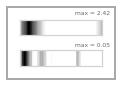

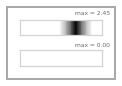

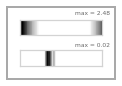

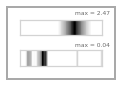

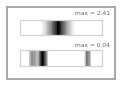

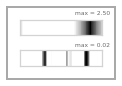

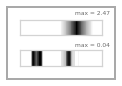

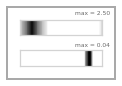

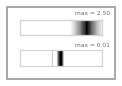

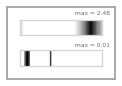

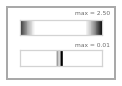

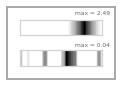

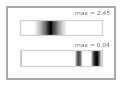

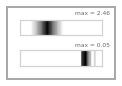

In [19]:
for _ in range(n_samples):
    idx = np.random.choice(n_units)
    fig, axs = plt.subplots(2, 1, figsize=(1.5, 1.))
    _place_acts = place_inputs[:, idx]
    _ff_acts = ff_barcodes[-1, :, idx]
    place_maxlim = _place_acts.max()
    barcode_maxlim = _ff_acts.max()
    axs[0].imshow(
        _place_acts.reshape((1,-1)),
        aspect='auto', cmap='binary',
        clim=(0, place_maxlim))
    axs[1].imshow(
        _ff_acts.reshape((1,-1)),
        aspect='auto', cmap='binary',
        clim=(0, barcode_maxlim))


    # Add text annotations above the figure with the maximum value
    fig.text(0.95, 0.95, f'max = {place_maxlim:.2f}', 
             ha='right', va='top',
             transform=fig.transFigure, fontsize=6)
    fig.text(0.95, 0.50, f'max = {barcode_maxlim:.2f}', 
             ha='right', va='top',
             transform=fig.transFigure, fontsize=6)
    
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.set_yticks([])
        ax.set_xticks([])
        
    # Add a box around the entire figure
    rect = patches.Rectangle(
        (0, 0), 1, 1, transform=fig.transFigure,
        facecolor='none', edgecolor='darkgrey', linewidth=2)
    fig.patches.append(rect)
    plt.tight_layout()
    
    plt.savefig(f'figures/ff_firing_fields/{idx}.svg', dpi=300)
    plt.show()